## Problem 1

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('hw07train.csv',header=None).to_numpy()
test = pd.read_csv('hw07test.csv',header=None).to_numpy()

In [3]:
train

array([[-1.1994, -1.6741,  1.    ,  0.    ],
       [ 1.6387,  0.8442,  1.    ,  0.    ],
       [-0.859 , -2.0612,  1.    ,  0.    ],
       ...,
       [ 2.7615, -1.1492,  0.    ,  1.    ],
       [ 0.3856,  0.8318,  0.    ,  1.    ],
       [-0.6849,  0.8582,  0.    ,  1.    ]])

In [4]:
test

array([[ 0.4288,  0.6433,  1.    ,  0.    ],
       [ 1.3545,  1.1607,  1.    ,  0.    ],
       [-1.1   , -0.1392,  1.    ,  0.    ],
       ...,
       [ 3.1781, -1.2834,  0.    ,  1.    ],
       [ 0.8916, -0.7417,  0.    ,  1.    ],
       [ 0.2892, -2.4596,  0.    ,  1.    ]])

In [5]:
X = train[:,0:2]
[K,d]  = np.shape(X)

C = 2

Label = np.mat([train[:,2] == 1, train[:,2] == 0]).T

In [6]:
Iv = [[]] * 5
Ir = [[]] * 5
for m in range(5):
    Iv[m] = range(m,K,5) # Indices of 10 validation sets.
    Ir[m] = np.setdiff1d(range(K),Iv[m])

In [7]:
Iv[0]

range(0, 500, 5)

In [8]:
Ir[0]

array([  1,   2,   3,   4,   6,   7,   8,   9,  11,  12,  13,  14,  16,
        17,  18,  19,  21,  22,  23,  24,  26,  27,  28,  29,  31,  32,
        33,  34,  36,  37,  38,  39,  41,  42,  43,  44,  46,  47,  48,
        49,  51,  52,  53,  54,  56,  57,  58,  59,  61,  62,  63,  64,
        66,  67,  68,  69,  71,  72,  73,  74,  76,  77,  78,  79,  81,
        82,  83,  84,  86,  87,  88,  89,  91,  92,  93,  94,  96,  97,
        98,  99, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113,
       114, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129,
       131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 146,
       147, 148, 149, 151, 152, 153, 154, 156, 157, 158, 159, 161, 162,
       163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177, 178,
       179, 181, 182, 183, 184, 186, 187, 188, 189, 191, 192, 193, 194,
       196, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 209, 211,
       212, 213, 214, 216, 217, 218, 219, 221, 222, 223, 224, 22

In [9]:
  def actfn(u,tp=1, par=1):
    # Usage: [y,yp]=actfunp(u, tp, par)
    # Compute activation functions and their derivatives
    # u: net function, a K x N matrix
    # y: activation function, a K x N matrix
    # tp: 1 - sigmoid, 2 - tanh, 3- linear, 4 - radial 5 - softmax
    #       6 - ReLu,  7, Hardlim (step)
    # par: parameter list
    #    sigmoid: T,  y=1/(1+exp(-u/T)), yp=y*(1-y)/T
    #    tanh: T,     y=(exp(u/T)-exp(-u/T))/(exp(u/T)+exp(-u/T))
    #                 yp=(1-y*y)/T
    #    linear:m,b   y=au+b, yp=a
    #    radial:m,sig y=exp(-(u-m)^2/sig^2), yp=-2(u-m)*y/sig^2
    #    softmax: y = exp(u)/sum(exp(u(k,:)), yp(k) = y(k)*(1-y(k))
    #    ReLU:  y = u if u >0 and = 0 otherwise.  yp = 1 if u > 0 and = 0 o.w.
    #    Step, hardlim: y = 1 if u>=0, = 0 if u < 0, yp = 0 for all u

    (K,N) = np.shape(u)

    if tp == 1:
        T = 1
        y = np.reciprocal(1 + np.exp(-u/T))
        yp  = np.multiply(y, np.ones(np.shape(y)) - y)/T
    if tp == 2:
        T = 1
        tmp = np.exp(u/T)
        y = np.divide(tmp - np.reciprocal(tmp),tmp + np.reciprocal(tmp))
        yp = (np.ones(np.shape(y)) - np.multiply(y, y))/T
    if tp == 3:
        a = 1
        b = 0
        y = a*u + b
        yp = a* np.ones(np.shape(y))
    if tp == 4:
        m = 0
        sig = 1
        s = sig**2
        tmp = np.multiply(u - m, u - m)
        y = np.exp(-tmp/s)
        yp = np.multiply((-2/s) * (u - m), y)
    if tp == 5:
        eu = np.exp(u)
        sv = np.mat(np.sum(eu,axis=1)).T
        y = np.divide(eu, sv*np.ones((1,N)))
        yp = np.multiply(y,np.ones((K,N)) - y)
    if tp == 6:
        yp = (u > 0).astype(int)
        y = np.multiply(u, yp)
    if tp == 7:
        yp = np.zeros(np.shape(u))
        y = (u >= 0).astype(int)
 
    return y, yp

In [10]:
class mlpdef:
    def __init__(self, d,C,Lsize = [],ActFn=[2,1]):
        if len(Lsize) == 0:
            Lsize = [2, C]
        self.Nlayers = len(Lsize)
        self.Lsize = Lsize
        self.ActFn = ActFn
        self.FeatureDim = d
        self.OutDim = C

        self.W = [[]] * self.Nlayers
        self.W[0] = 0.01 * np.random.randn(d+1, self.Lsize[0])
        for n in range(1,self.Nlayers):
            self.W[n] = 0.01 * np.random.randn(self.Lsize[n-1] + 1, self.Lsize[n])
        
        self.A = [[]] * self.Nlayers
        self.Ap = [[]] * self.Nlayers

    def train(self, X, y, para):
        #Train the network using the backpropagation algorithm.
        #1. setup parameters
        K,d = np.shape(X)
        Kr = para["epoch"]
        dw = [[]] * self.Nlayers
        delta = [[]] * self.Nlayers
        # 2. Start each epoch
        for m in range(para["Nepoch"]):
            # 2a. Draw Kr samples randomly from X for current epoch
            ide  = np.random.choice(range(K),Kr)
            Xr = X[ide,:]
            Lr = y[ide,:]

            # 2b. feed forward output and error
            self.ffnet(Xr)
            # 2c. Delta Error Back-Propagation
            # compute output error and delta errors at each layer
            # delta error is computed for each neuron. The bias input is a constant
            # and has no parent node. and has no delta error. 
            error = Lr - self.A[self.Nlayers - 1]
            delta[self.Nlayers - 1] = np.multiply(self.Ap[self.Nlayers - 1], error)
            for n in reversed(range(self.Nlayers-1)):
              # delta{n}=mlp.Ap{n}.*(delta{n+1}*(mlp.W{n+1}(2:end,:))');
              delta[n] =np.multiply(self.Ap[n],np.dot(delta[n+1], self.W[n+1][1:,:].T))
            # 2d. Weight update
            # initialize weight updates dw using delta error
            dw[0] = np.zeros((d+1, self.Lsize[0]))
            for n in range(1,self.Nlayers):
                dw[n] = np.zeros((self.Lsize[n-1] + 1, self.Lsize[n]))

            one_mat = np.ones((Kr,1))
            dw[0] = np.dot(para["LR"]*np.concatenate((one_mat,Xr),axis=1).T,delta[0]) + np.dot(para["Mom"],dw[0]) + 0.01 * np.random.randn(np.shape(dw[0])[0],np.shape(dw[0])[1])
            self.W[0] += dw[0]
            for n in range(1,self.Nlayers):
                dw[n] = np.dot(para["LR"]*np.concatenate((one_mat,self.A[n - 1]),axis=1).T,delta[n]) + np.dot(para["Mom"],dw[n]) + 0.01 * np.random.randn(np.shape(dw[n])[0],np.shape(dw[n])[1])
                self.W[n] += dw[n]
                                              

    def eval(self, Xr, Lr, Xv, Lv):
        # Evaluate the classification error of the network.
        Kr, C = np.shape(Lr)
        Kv = np.shape(Lv)[0]
        Ic = np.eye(C)
    
        self.ffnet(Xr)
        out = self.A[self.Nlayers -1]
        err_train  = Lr - out
        er = np.sum(np.square(np.sum(err_train))) / np.dot(Kr, C)
        idx = np.argmax(out,axis=1).flatten()
        Cmatr = np.dot(Lr.T, Ic[idx, :])

        self.ffnet(Xv)
        out = self.A[self.Nlayers - 1]
        err_test = Lv - out
        et = np.sum(np.square(np.sum(err_test))) / np.dot(Kv, C)
        idx = np.argmax(out,axis=1).flatten()
        Cmatt = np.dot(Lv.T, Ic[idx,:])

        return er, et, Cmatr, Cmatt
  
    def ffnet(self, X):
        # Feed data forward through the network.
        K = np.shape(X)[0]
        one_mat = np.ones((K,1))
        u = np.dot(np.concatenate((one_mat,X),axis=1),self.W[0])
        self.A[0], self.Ap[0] = actfn(u,self.ActFn[0])
        for n in range(1,self.Nlayers):
            u = np.dot(np.concatenate((one_mat,self.A[n-1]),axis=1),self.W[n])
            self.A[n], self.Ap[n] = actfn(u,self.ActFn[n])

In [11]:
para = {}
para["LR"] = 0.1
para["Mom"] = 0.8
para["epoch"] = 10
para["Nepoch"] = 10

Training Confusion Matrix: 
[[172.  28.]
 [ 54. 146.]]
Epoch #: 100
Validation Confusion Matrix: 
[[48.  2.]
 [14. 36.]]
Training Confusion Matrix: 
[[172.  28.]
 [ 58. 142.]]
Epoch #: 200
Validation Confusion Matrix: 
[[47.  3.]
 [14. 36.]]
Training Confusion Matrix: 
[[172.  28.]
 [ 53. 147.]]
Epoch #: 300
Validation Confusion Matrix: 
[[47.  3.]
 [13. 37.]]
Training Confusion Matrix: 
[[184.  16.]
 [ 59. 141.]]
Epoch #: 400
Validation Confusion Matrix: 
[[48.  2.]
 [19. 31.]]
Training Confusion Matrix: 
[[172.  28.]
 [ 42. 158.]]
Epoch #: 500
Validation Confusion Matrix: 
[[46.  4.]
 [14. 36.]]
Training Confusion Matrix: 
[[157.  43.]
 [ 35. 165.]]
Epoch #: 600
Validation Confusion Matrix: 
[[45.  5.]
 [12. 38.]]
Training Confusion Matrix: 
[[174.  26.]
 [ 45. 155.]]
Epoch #: 700
Validation Confusion Matrix: 
[[47.  3.]
 [18. 32.]]
Training Confusion Matrix: 
[[180.  20.]
 [ 47. 153.]]
Epoch #: 800
Validation Confusion Matrix: 
[[48.  2.]
 [17. 33.]]
Training Confusion Matrix: 
[[17

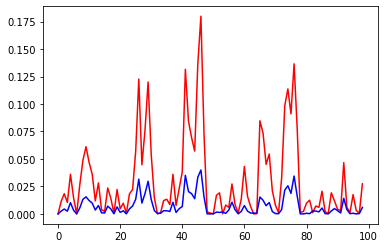

In [12]:
import matplotlib.pyplot as plt

fnet = mlpdef(d,C,[4, C], [2,1])

Xr = X[Ir[0],:]
Lr = Label[Ir[0],:]
Xv = X[Iv[0],:]
Lv = Label[Iv[0],:]

Converged = False
iter = 0
itermax = 100
Er = np.zeros(itermax)
Et = np.zeros(itermax)
while not Converged:
    iter = iter + 1
    fnet.train(Xr, Lr, para)
    Er[iter], Et[iter],Cmatr, Cmatt = fnet.eval(Xr,Lr, Xv, Lv)
    if (iter % 10) == 0:
        print("Training Confusion Matrix: \n" + str(Cmatr))
        print("Epoch #: " + str(iter * para["Nepoch"]))
        print("Validation Confusion Matrix: \n" + str(Cmatt))

    if iter >= itermax - 1:
        Converged = True
        print("Reached Max iteration #: " + str(iter) + ", Stop!")

plt.plot(range(iter), Er[range(iter)],'r')
plt.plot(range(iter), Et[range(iter)],'b')
plt.show()

In [13]:
X = test[:,0:2]
[K,d]  = np.shape(X)

C = 2

Label = np.mat([test[:,2] == 1, test[:,2] == 0]).T

Er, Et,Cmatr, Cmatt = fnet.eval(X,Label, X, Label)
print("Testing Confusion Matrix: \n" + str(Cmatr))

Testing Confusion Matrix: 
[[221.  29.]
 [ 73. 177.]]


## Problem 2

In [14]:
from sklearn.neural_network import MLPClassifier

In [15]:
X = train[:,0:2]

Label = train[:,2:3]

clf = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(4, 4), random_state=1)

clf.fit(X, Label)

/home/hp/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(4, 4), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [16]:
X = test[:,0:2]

Label = test[:,2:3]

y = clf.predict(X)

y

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Label, y)

array([[184,  66],
       [ 26, 224]])